In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Long Short Term Memory
![LSTM](data/LSTM3-chain.png "LSTM")

输入门 it：控制有多少信息可以流入memory cell。

遗忘门 ft：控制有多少上一时刻的memory cell中的信息可以累积到当前时刻的memory cell中。

输出门 ot：控制有多少当前时刻的memory cell中的信息可以流入当前隐藏状态 ht中。

https://zhuanlan.zhihu.com/p/25518711?group_id=820633644749185024

In [2]:
class LSTMcell(object):
    def __init__(self, incoming, D_input, D_cell, weight_initializer, f_bias=1.0):
        # Args:
        # incoming: used for accepting input data, shape=[n_samples, n_steps, D_input]
        # D_input: scalar, dim of input
        # D_cell: scalar, dim of hidden state and memory cell
        # weight_initializer: function for initializing weight params
        # f_bias: scalar
        
        self.incoming = incoming
        self.D_input = D_input
        self.D_cell =D_cell
        
        # init params for forget gate layer
        self.W_xf = weight_initializer([self.D_input, self.D_cell])
        self.W_hf = weight_initializer([self.D_cell, self.D_cell])
        self.b_f = tf.Variable(tf.constant(f_bias, shape=[self.D_cell]))
        
        # init params for input gate layer
        self.W_xi = weight_initializer([self.D_input, self.D_cell])
        self.W_hi = weight_initializer([self.D_cell, self.D_cell])
        self.b_i = tf.Variable(tf.zeros([self.D_cell]))
        
        # init params for cell state
        self.W_xc = weight_initializer([self.D_input, self.D_cell])
        self.W_hc = weight_initializer([self.D_cell, self.D_cell])
        self.b_c = tf.Variable(tf.zeros([self.D_cell])) 
        
        # init params for output gate layer
        self.W_xo = weight_initializer([self.D_input, self.D_cell])
        self.W_ho = weight_initializer([self.D_cell, self.D_cell])
        self.b_o = tf.Variable(tf.zeros([self.D_cell]))
        
        # init cell state and hidden state, both shape=[n_samples, D_cell]
        init_for_both = tf.matmul(self.incoming[:,0,:], tf.zeros([D_input, D_cell]))
        self.cell_init = init_for_both
        self.hidden_init = init_for_both
        
        # arguments for tf.scan
        self.previous_h_c_tuple = tf.stack([self.hidden_init, self.cell_init], axis=0)
        
        # change the shape of incoming to [n_steps, n_samples, D_input] for tf.scan
        self.incoming = tf.transpose(self.incoming, perm=[1,0,2])
        
    
    def one_step(self, previous_h_c_tuple, current_x):
        # Args:
        # previous_h_c_tuple: tuple of (previous_hidden_state, previous_cell_state)
        # current_x: current input
        # Return:
        # tuple of (current_hidden_state, current_cell_state)
        
        prev_hidden, prev_cell = tf.unstack(previous_h_c_tuple)
        
        # cal forget gate
        f = tf.sigmoid(tf.matmul(current_x, self.W_xf) + 
                          tf.matmul(prev_hidden, self.W_hf + self.b_f))
        
        # cal input gate
        i = tf.sigmoid(tf.matmul(current_x, self.W_xi) + 
                          tf.matmul(prev_hidden, self.W_hi + self.b_i))
        
        # cal current cell
        c = tf.tanh(tf.matmul(current_x, self.W_xc) + 
                          tf.matmul(prev_hidden, self.W_hc + self.b_c))
        cur_cell = prev_cell*f + i*c
        
        # cal current hidden
        o = tf.sigmoid(tf.matmul(current_x, self.W_xo) + 
                          tf.matmul(prev_hidden, self.W_ho + self.b_o))
        cur_hidden = tf.tanh(cur_cell)*o 
        
        return tf.stack([cur_hidden, cur_cell])
    
    def all_steps(self):
        lstm = tf.scan(fn=self.one_step, elems=self.incoming, 
                                initializer=self.previous_h_c_tuple, name="lstm")
        # Args:
        # fn: function, accepts two arguments, 
        #     first one is the output of the previous step of calling 'fn'
        #     second one is the current input unpack from 'elems' on dim 0
        # elems: a list of tensors. shape=[n_steps, n_samples, D_input]
        # initializer: intial values for the first argument in 'fn'
        # Return:
        # shape=[n_steps,2, n_samples, D_cell], 
        # the second dimension 2 composes of hidden state and memory cell
        
        hidden_states = lstm[:,0,:,:]    #shape=[n_steps, n_samples, D_cell]
        return hidden_states

In [3]:
def weight_init(shape):
    initial = tf.random_uniform(shape=shape, 
                                minval=-np.sqrt(5)*np.sqrt(1.0/shape[0]), 
                                maxval=np.sqrt(5)*np.sqrt(1.0/shape[0]))
    return tf.Variable(initial, trainable=True)

def zero_init(shape):
    return tf.Variable(tf.zeros(shape), trainable=True)

def orthogonal_initializer(shape,scale = 1.0):
    #https://github.com/Lasagne/Lasagne/blob/master/lasagne/init.py
    scale = 1.0
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.normal(0.0, 1.0, flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.reshape(shape) #this needs to be corrected to float32
    return tf.Variable(scale * q[:shape[0], :shape[1]],trainable=True, dtype=tf.float32)

def bias_init(shape):
    return tf.Variable(tf.constant(0.01, shape=shape))

In [4]:
import utils
data = utils.loadXY()
n_samples = len(data)
split_size=0.8
train_data=data[:int(n_samples*split_size)]
test_data=data[int(n_samples*split_size):]
print("Num of train samples: {}".format(len(train_data)))
print("Num of test samples: {}".format(len(test_data)))

loading data ......
Samples: 103
Input shape: (886, 39)
Labels shape: (886, 24)
Standardizing ......
Num of train samples: 82
Num of test samples: 21


In [5]:
D_input = 39
D_label = 24
learning_rate = 7e-5
lstm_size=128

inputs_ = tf.placeholder(shape=[None, None, D_input], dtype=tf.float32, name="inputs")
labels_ = tf.placeholder(shape=[None, D_label], dtype=tf.float32, name="labels")

step = tf.Variable(0,dtype=tf.int32,name="global_step", trainable=False)

rnn_cell = LSTMcell(inputs_, D_input, lstm_size, orthogonal_initializer)

rnn_output = rnn_cell.all_steps()    #shape=[n_steps, n_samples, D_cell]
tf.summary.histogram('rnn_output', rnn_output)
fc_input = tf.reshape(rnn_output, [-1, lstm_size])

W = weight_init([lstm_size, D_label])
b = bias_init([D_label])
output = tf.add(tf.matmul(fc_input, W), b, name="output")
tf.summary.tensor_summary('output', output)

cost = tf.reduce_mean((output-labels_)**2, name="cost")
tf.summary.scalar('cost', cost)

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost,global_step=step, name="opt")

summary = tf.summary.merge_all()

In [8]:
epoches=20
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('data/lstm_graph', sess.graph)
    for e in range(epoches):
        train_data_e = utils.shuffle_list(train_data)
        train_costs=[]
        test_costs=[]
        for i in range(len(train_data_e)):
            loss,summaries,global_step, _ = sess.run([cost,summary,step,optimizer], 
                                   feed_dict={inputs_:train_data_e[i][0], labels_:train_data_e[i][1]})
            #print("Epoch {}: train_cost = {:.4f}".format(e+1, loss))
            writer.add_summary(summaries,global_step=global_step)
            train_costs.append(loss)
        for i in range(len(test_data)):
            loss = sess.run(cost,feed_dict={inputs_:test_data[i][0], labels_:test_data[i][1]})
            test_costs.append(loss)
        print("Epoch {}: train_cost = {:.4f}, test_cost = {:.4f}".format(e+1, np.mean(train_costs), np.mean(test_costs)))
    saver.save(sess, "data/lstm_checkpoints/lstm.ckpt")
    writer.flush()                 
    writer.close()

Epoch 1: train_cost = 1.0075, test_cost = 0.9844
Epoch 2: train_cost = 0.9694, test_cost = 0.9453
Epoch 3: train_cost = 0.9229, test_cost = 0.8867
Epoch 4: train_cost = 0.8652, test_cost = 0.8353
Epoch 5: train_cost = 0.8182, test_cost = 0.7935
Epoch 6: train_cost = 0.7756, test_cost = 0.7553
Epoch 7: train_cost = 0.7387, test_cost = 0.7283
Epoch 8: train_cost = 0.7093, test_cost = 0.7058
Epoch 9: train_cost = 0.6853, test_cost = 0.6883
Epoch 10: train_cost = 0.6652, test_cost = 0.6730
Epoch 11: train_cost = 0.6473, test_cost = 0.6591
Epoch 12: train_cost = 0.6316, test_cost = 0.6485
Epoch 13: train_cost = 0.6174, test_cost = 0.6391
Epoch 14: train_cost = 0.6040, test_cost = 0.6275
Epoch 15: train_cost = 0.5919, test_cost = 0.6212
Epoch 16: train_cost = 0.5804, test_cost = 0.6148
Epoch 17: train_cost = 0.5700, test_cost = 0.6076
Epoch 18: train_cost = 0.5597, test_cost = 0.6024
Epoch 19: train_cost = 0.5505, test_cost = 0.5943
Epoch 20: train_cost = 0.5416, test_cost = 0.5897


INFO:tensorflow:Restoring parameters from data/lstm_checkpoints\lstm.ckpt


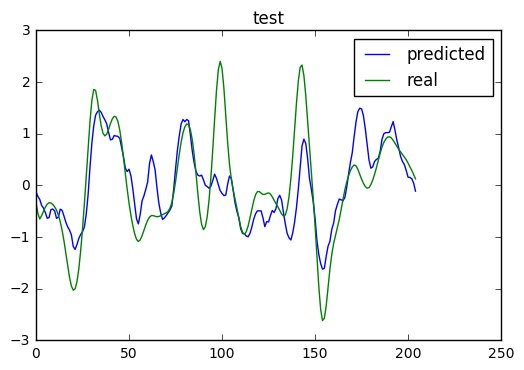

In [9]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint('data/lstm_checkpoints'))
    pY = sess.run(output, feed_dict={inputs_:test_data[10][0]})
plt.plot(pY[:,8])
plt.plot(test_data[10][1][:,8])
plt.title('test')
plt.legend(['predicted','real'])
plt.show()

INFO:tensorflow:Restoring parameters from data/lstm_checkpoints\lstm.ckpt


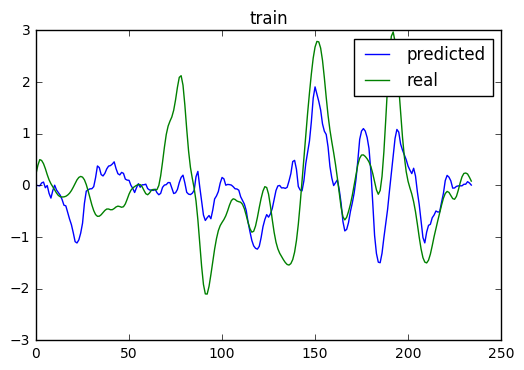

In [10]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint('data/lstm_checkpoints'))
    pY = sess.run(output, feed_dict={inputs_:train_data[10][0]})
plt.plot(pY[:,8])
plt.plot(train_data[10][1][:,8])
plt.title('train')
plt.legend(['predicted','real'])
plt.show()

In [11]:
print(train_data[0][0].shape)
print(train_data[10][0].shape)
print(train_data[20][0].shape)
print(train_data[0][1].shape)
print(train_data[10][1].shape)
print(train_data[20][1].shape)

(1, 886, 39)
(1, 235, 39)
(1, 147, 39)
(886, 24)
(235, 24)
(147, 24)
